# Comparação de Algumas Implementações do NSGA

#### NSGA-II
No código a seguir temos uma implementação simplificada do NSGA-II

In [1]:
import numpy as np
import random

# Algoritmo NSGA-II
def nsga2(pop_size, generations, bounds, initial_population=None):
    # Funções de avaliação
    def f1(x):
        return (x - 2)**2

    def f2(x):
        return (x + 2)**2

    # Inicialização da população
    def initialize_population(size, bounds):
        return [random.uniform(bounds[0], bounds[1]) for _ in range(size)]

    # Avaliação
    def evaluate_population(population):
        return [(f1(x), f2(x)) for x in population]

    # Ordenação não-dominada eficiente
    def fast_nondominated_sort(objectives):
        fronts = [[]]
        domination_count = [0] * len(objectives)
        dominated_solutions = [[] for _ in range(len(objectives))]

        for p in range(len(objectives)):
            for q in range(len(objectives)):
                if dominates(objectives[p], objectives[q]):
                    dominated_solutions[p].append(q)
                elif dominates(objectives[q], objectives[p]):
                    domination_count[p] += 1

            if domination_count[p] == 0:
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in dominated_solutions[p]:
                    domination_count[q] -= 1
                    if domination_count[q] == 0:
                        next_front.append(q)
            i += 1
            fronts.append(next_front)

        fronts.pop()
        return fronts

    # Dominância
    def dominates(obj1, obj2):
        return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

    # Distância de crowding
    def crowding_distance(front, objectives):
        if len(front) == 1:
            return [float('inf')]
        
        distances = [0] * len(front)
        for m in range(len(objectives[0])):
            sorted_front = sorted(range(len(front)), key=lambda i: objectives[front[i]][m])
            distances[sorted_front[0]] = distances[sorted_front[-1]] = float('inf')
            for i in range(1, len(front) - 1):
                distances[sorted_front[i]] += (
                    objectives[front[sorted_front[i + 1]]][m] - objectives[front[sorted_front[i - 1]]][m]
                )
        return distances

    # Seleção com elitismo
    def select_next_population(fronts, objectives, population, pop_size):
        next_population = []
        for front in fronts:
            if len(next_population) + len(front) <= pop_size:
                next_population.extend(front)
            else:
                distances = crowding_distance(front, objectives)
                sorted_front = sorted(zip(front, distances), key=lambda x: x[1], reverse=True)
                next_population.extend([solution for solution, _ in sorted_front[:pop_size - len(next_population)]])
                break
        return [population[i] for i in next_population]  # Seleciona os indivíduos correspondentes

    # Cruzamento
    def crossover(parent1, parent2):
        return (parent1 + parent2) / 2

    # Mutação
    def mutation(individual, bounds, mutation_rate=0.5):
        if random.random() < mutation_rate:
            individual += random.uniform(-0.1, 0.1)
            individual = np.clip(individual, bounds[0], bounds[1])  # Garante que o valor permaneça nos limites
        return individual

    if initial_population is None:
        population = initialize_population(pop_size, bounds)
    else:
        population = initial_population

    for gen in range(generations):
        # Avaliar a nova população
        objectives = evaluate_population(population)
        fronts = fast_nondominated_sort(objectives)

        # Criar descendentes usando operadores genéticos
        offspring = []
        while len(offspring) < pop_size:
            parent1, parent2 = random.sample(population, 2)            
            child = crossover(parent1, parent2)
            child = mutation(child, bounds)            
            offspring.append(child)
            
        # Combinar pais e descendentes
        combined_population = population + offspring
        combined_objectives = evaluate_population(combined_population)
        
        # Realizar nova ordenação não-dominada
        combined_fronts = fast_nondominated_sort(combined_objectives)
        
        # Selecionar próxima geração com elitismo
        population = select_next_population(combined_fronts, combined_objectives, combined_population, pop_size)

    # Final evaluation
    objectives = evaluate_population(population)
    fronts = fast_nondominated_sort(objectives)
    pareto_front = [objectives[i] for i in fronts[0]]
    pareto_front.sort()
    return pareto_front


#### NSGA-III

No código a seguir apresentamos uma implementação do NSGA-III

In [2]:
import numpy as np
import random
from collections import defaultdict

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

def nsga3(pop_size, generations, bounds, base_mutation_rate=0.1, divisions=4, initial_population=None, ref_points=None):
    # Objective functions
    def f1(x):
        return (x - 2) ** 2

    def f2(x):
        return (x + 2) ** 2

    # Population initialization
    def initialize_population(size, bounds):
        return [random.uniform(bounds[0], bounds[1]) for _ in range(size)]

    # Evaluation
    def evaluate_population(population):
        return [(f1(x), f2(x)) for x in population]

    # Dominance
    def dominates(obj1, obj2):
        return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

    # Non-dominated sorting
    def fast_nondominated_sort(objectives):
        population_size = len(objectives)
        S = [[] for _ in range(population_size)]
        n = [0] * population_size
        rank = [0] * population_size
        fronts = [[]]

        for p in range(population_size):
            for q in range(population_size):
                if dominates(objectives[p], objectives[q]):
                    S[p].append(q)
                elif dominates(objectives[q], objectives[p]):
                    n[p] += 1
            if n[p] == 0:
                rank[p] = 0
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in S[p]:
                    n[q] -= 1
                    if n[q] == 0:
                        rank[q] = i + 1
                        next_front.append(q)
            i += 1
            fronts.append(next_front)
        fronts.pop()
        return fronts

    # Generate reference points
    def generate_reference_points(M, p):
        def generate_recursive(points, num_objs, left, total, depth, current_point):
            if depth == num_objs - 1:
                current_point.append(left / total)
                points.append(current_point.copy())
                current_point.pop()
            else:
                for i in range(left + 1):
                    current_point.append(i / total)
                    generate_recursive(points, num_objs, left - i, total, depth + 1, current_point)
                    current_point.pop()
        points = []
        generate_recursive(points, M, p, p, 0, [])
        return np.array(points)

    # Environmental selection
    def environmental_selection(population, objectives, fronts, reference_points, pop_size):
        next_population_indices = []
        for front in fronts:
            if len(next_population_indices) + len(front) <= pop_size:
                next_population_indices.extend(front)
            else:
                N = pop_size - len(next_population_indices)
                selected_indices = niching_selection(front, objectives, reference_points, N)
                next_population_indices.extend(selected_indices)
                break
        next_population = [population[i] for i in next_population_indices]
        return next_population

    # Niching selection
    def niching_selection(front, objectives, reference_points, N):
        selected = []
        # Normalize objectives
        objs = np.array([objectives[i] for i in front])
        ideal_point = np.min(objs, axis=0)
        normalized_objs = objs - ideal_point

        # Avoid division by zero
        max_values = np.max(normalized_objs, axis=0)
        max_values[max_values == 0] = 1
        normalized_objs = normalized_objs / max_values

        # Associate each individual with the nearest reference point
        associations = []
        for idx, obj in zip(front, normalized_objs):
            distances = np.linalg.norm(obj - reference_points, axis=1)
            min_index = np.argmin(distances)
            associations.append((idx, min_index, distances[min_index]))

        # Build a dictionary of associations
        reference_associations = defaultdict(list)
        for idx, ref_idx, dist in associations:
            reference_associations[ref_idx].append((idx, dist))

        # Niche counts
        niche_counts = {i: 0 for i in range(len(reference_points))}
        selected_flags = {idx: False for idx in front}

        while len(selected) < N:
            # Find reference points with minimum niche count
            min_niche_count = min(niche_counts.values())
            min_refs = [ref for ref, count in niche_counts.items() if count == min_niche_count]

            for ref_idx in min_refs:
                # Get unselected individuals associated with this reference point
                assoc_inds = reference_associations.get(ref_idx, [])
                unselected_inds = [(idx, dist) for idx, dist in assoc_inds if not selected_flags[idx]]

                if unselected_inds:
                    # Select the individual with the minimum distance
                    unselected_inds.sort(key=lambda x: x[1])
                    selected_idx = unselected_inds[0][0]
                    selected.append(selected_idx)
                    selected_flags[selected_idx] = True
                    niche_counts[ref_idx] += 1
                    break  # Move to the next reference point

            else:
                # If no individuals can be selected, select randomly from unselected individuals
                remaining = [idx for idx in front if not selected_flags[idx]]
                if remaining:
                    selected_idx = random.choice(remaining)
                    selected.append(selected_idx)
                    selected_flags[selected_idx] = True
                else:
                    break  # All individuals have been selected

        return selected[:N]

    # Precompute ranks for tournament selection
    def compute_individual_ranks(fronts):
        individual_ranks = {}
        for rank, front in enumerate(fronts):
            for idx in front:
                individual_ranks[idx] = rank
        return individual_ranks

    # Tournament selection
    def tournament_selection(population, individual_ranks):
        i1, i2 = random.sample(range(len(population)), 2)
        rank1 = individual_ranks[i1]
        rank2 = individual_ranks[i2]
        if rank1 < rank2:
            return population[i1]
        elif rank2 < rank1:
            return population[i2]
        else:
            return population[random.choice([i1, i2])]

    # Crossover
    def crossover(parent1, parent2):
        w = random.uniform(0, 1)
        return w * parent1 + (1 - w) * parent2

    # Mutation
    def mutation(individual, bounds, mutation_rate):
        if random.random() < mutation_rate:
            mutation_amount = random.uniform(-0.1, 0.1)
            individual += mutation_amount
            individual = np.clip(individual, bounds[0], bounds[1])
        return individual


    if initial_population is None:
        population = initialize_population(pop_size, bounds)
    else:
        population = initial_population
        
    M = 2  # Number of objectives
    if ref_points is None:
        ref_points = generate_reference_points(M, divisions)
        
    # NSGA-III Algorithm
    for gen in range(generations):
        # Evaluate current population
        objectives = evaluate_population(population)
        # Non-dominated sorting
        fronts = fast_nondominated_sort(objectives)
        # Compute individual ranks
        individual_ranks = compute_individual_ranks(fronts)
        
        # Generate offspring
        offspring_population = []
        while len(offspring_population) < pop_size:
            # Selection
            parent1 = tournament_selection(population, individual_ranks)
            parent2 = tournament_selection(population, individual_ranks)
            # Crossover
            child = crossover(parent1, parent2)
            # Mutation
            mutation_rate = base_mutation_rate * (1 - gen / generations)
            child = mutation(child, bounds, mutation_rate)
            offspring_population.append(child)

        # Combine populations
        combined_population = population + offspring_population
        # Evaluate combined population
        combined_objectives = evaluate_population(combined_population)
        # Non-dominated sorting on combined population
        combined_fronts = fast_nondominated_sort(combined_objectives)
        # Environmental selection
        population = environmental_selection(combined_population, combined_objectives, combined_fronts, ref_points
                                             , pop_size)

    # Final evaluation
    objectives = evaluate_population(population)
    fronts = fast_nondominated_sort(objectives)
    pareto_front = [objectives[i] for i in fronts[0]]
    pareto_front.sort()
    
    return pareto_front

#### NSGA-III DEAP

No código a seguir utilizamos a biblioteca DEAP para implementar o NSGA-III

In [3]:
import random
from deap import base, creator, tools

# Definição da função de avaliação
def evaluate(individual):
    x = individual[0]
    f1 = (x - 2)**2
    f2 = (x + 2)**2
    return f1, f2

def nsga3_deap(pop_size, generations=100, bounds=(-5, 5), divisions=4, initial_population=None, ref_points=None):
    # Criação das classes de fitness e indivíduo
    creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Minimização de ambas as funções
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Registro dos atributos, indivíduo e população
    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, bounds[0], bounds[1])
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate)

    # Registro dos operadores genéticos
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=bounds[0], up=bounds[1], eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=bounds[0], up=bounds[1], eta=20.0, indpb=1.0)
    toolbox.register("select", tools.selNSGA3)

    # Geração dos pontos de referência para o NSGA-III
    if ref_points is None:
        ref_points = tools.uniform_reference_points(nobj=2, p=divisions)
    
    # Inicialização da população
    if initial_population is not None:
        population = [creator.Individual(ind) for ind in initial_population]
    else:
        population = toolbox.population(n=pop_size)

    # Configurações do algoritmo
    CXPB = 0.5  # Probabilidade de crossover
    MUTPB = 0.1  # Probabilidade de mutação

    # Avaliação inicial da população
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Loop evolutivo
    for gen in range(generations):
        # Seleção dos indivíduos
        offspring = toolbox.select(population, len(population), ref_points=ref_points)

        # Clonagem dos indivíduos selecionados
        offspring = list(map(toolbox.clone, offspring))

        # Aplicação do crossover e mutação
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for ind in offspring:
            if random.random() <= MUTPB:
                toolbox.mutate(ind)
                del ind.fitness.values

        # Reavaliação dos indivíduos
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Atualização da população
        population = offspring

    # Extração da Frente de Pareto
    pareto_front = tools.sortNondominated(population, k=len(population), first_front_only=True)[0]

    result = []
    for ind in pareto_front:
        result.append([ind.fitness.values[0], ind.fitness.values[1]])
        
    return result


#### NSGA-III PYMOO

No código a seguir utilizamos a biblioteca pymoo para implementar o NSGA-III

In [4]:
import numpy as np
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.core.population import Population

def nsga3_pymoo(pop_size, generations=100, bounds=(-5, 5), divisions=4, initial_population=None, ref_points=None):
    class MyProblem(Problem):
        def __init__(self):
            super().__init__(n_var=1,
                             n_obj=2,
                             n_constr=0,                    
                             xl=np.array([bounds[0]]),
                             xu=np.array([bounds[1]]))

        def _evaluate(self, x, out, *args, **kwargs):
            f1 = (x - 2)**2
            f2 = (x + 2)**2
            out["F"] = np.column_stack([f1, f2])

    # Geração das direções de referência
    if ref_points is None:
        ref_points = get_reference_directions("uniform", 2, n_partitions=divisions)

    # Configuração do algoritmo NSGA-III
    algorithm = NSGA3(pop_size=pop_size, ref_dirs=ref_points)

    # Definição do problema
    problem = MyProblem()

    # Criação da população inicial, se fornecida
    if initial_population is not None:
        # Convertendo a população inicial para o formato da Pymoo
        initial_pop = Population.new("X", np.array(initial_population))
    else:
        # Usa a amostragem padrão para criar uma população inicial
        initial_pop = None

    # Execução da otimização
    res = minimize(problem,
                   algorithm,
                   termination=('n_gen', generations),
                   seed=1,
                   verbose=False,
                   save_history=False,
                   initial_population=initial_pop)

    # Retorna a Frente de Pareto final
    return res.F

## Comparações de Resultados

#### Teste Inicial

c:\Users\jcf_s\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


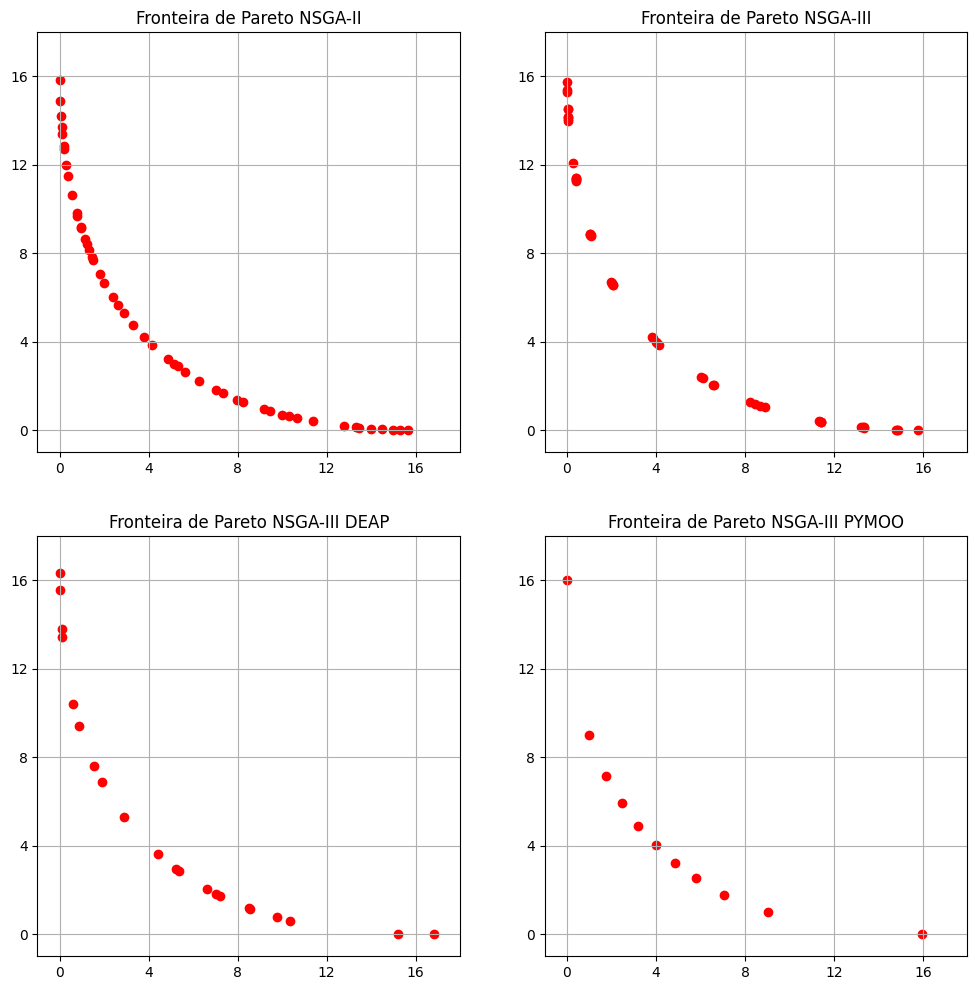

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

def plot(pareto_front, pos, text):
    plt.subplot(2, 2, pos)
    plt.scatter(*zip(*pareto_front), color="red")
    plt.title(f"Fronteira de Pareto {text}")
    plt.grid()
    plt.xticks(np.arange(0, 20, 4)) 
    plt.yticks(np.arange(0, 20, 4)) 
    plt.xlim([-1, 18])
    plt.ylim([-1, 18])

pop_size = 50
generations = 10
bounds = [-5,5]
divisions = 10

p1 = nsga2(pop_size=pop_size, generations=generations, bounds=bounds)
p2 = nsga3(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)
p3 = nsga3_deap(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)
p4 = nsga3_pymoo(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)

plot(p1, 1, "NSGA-II")
plot(p2, 2, "NSGA-III")
plot(p3, 3, "NSGA-III DEAP")
plot(p4, 4, "NSGA-III PYMOO")

#### Comportamento frente ao aumento das gerações

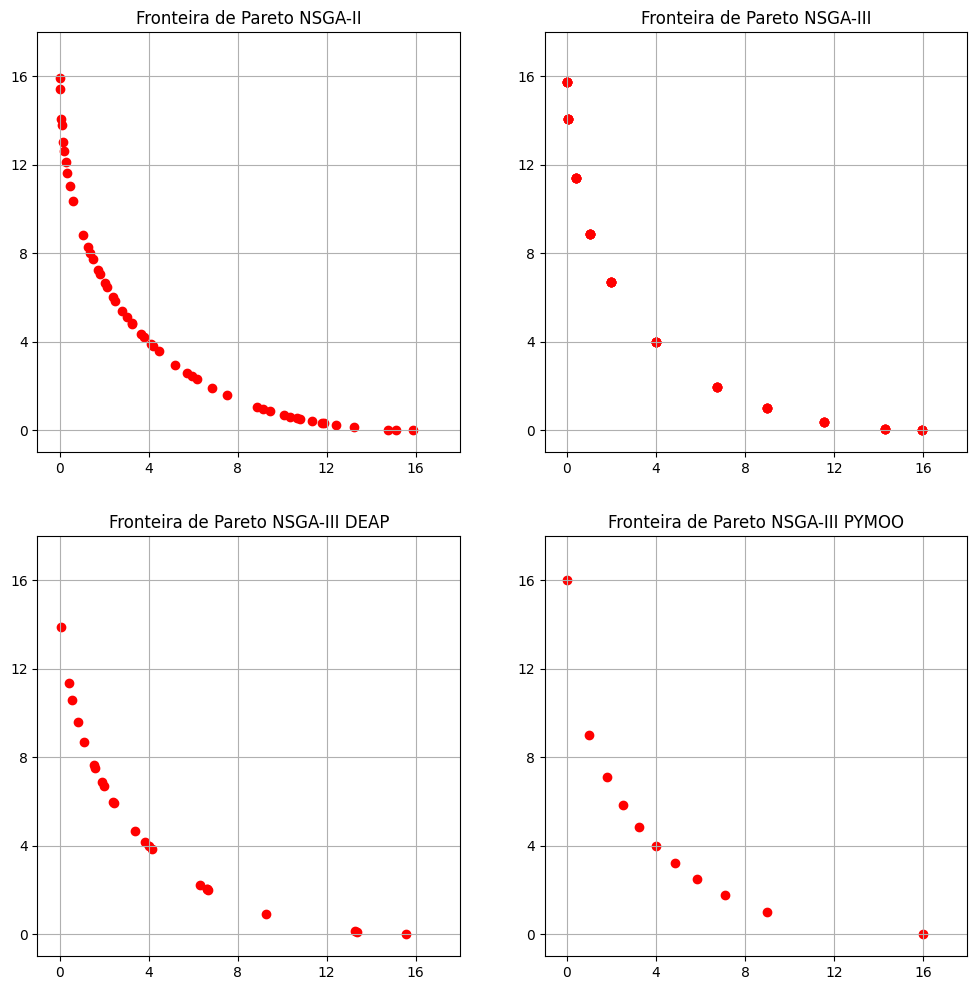

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

def plot(pareto_front, pos, text):
    plt.subplot(2, 2, pos)
    plt.scatter(*zip(*pareto_front), color="red")
    plt.title(f"Fronteira de Pareto {text}")
    plt.grid()
    plt.xticks(np.arange(0, 20, 4)) 
    plt.yticks(np.arange(0, 20, 4)) 
    plt.xlim([-1, 18])
    plt.ylim([-1, 18])

pop_size = 50
generations = 100
bounds = [-5,5]
divisions = 10

p1 = nsga2(pop_size=pop_size, generations=generations, bounds=bounds)
p2 = nsga3(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)
p3 = nsga3_deap(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)
p4 = nsga3_pymoo(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)

plot(p1, 1, "NSGA-II")
plot(p2, 2, "NSGA-III")
plot(p3, 3, "NSGA-III DEAP")
plot(p4, 4, "NSGA-III PYMOO")

#### Comportamento frente a redução da fronteira inicial

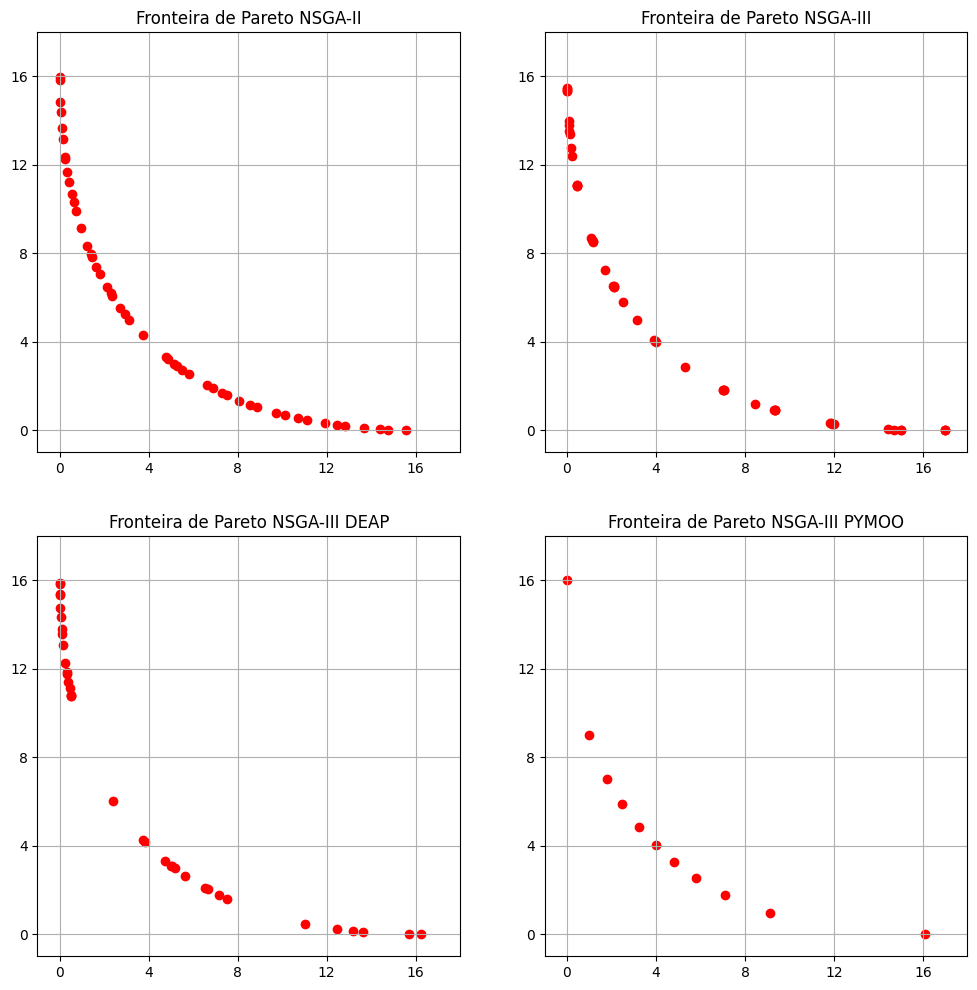

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

def plot(pareto_front, pos, text):
    plt.subplot(2, 2, pos)
    plt.scatter(*zip(*pareto_front), color="red")
    plt.title(f"Fronteira de Pareto {text}")
    plt.grid()
    plt.xticks(np.arange(0, 20, 4)) 
    plt.yticks(np.arange(0, 20, 4)) 
    plt.xlim([-1, 18])
    plt.ylim([-1, 18])

pop_size = 50
generations = 10
bounds = [-3,3]
divisions = 10

p1 = nsga2(pop_size=pop_size, generations=generations, bounds=bounds)
p2 = nsga3(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)
p3 = nsga3_deap(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)
p4 = nsga3_pymoo(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)

plot(p1, 1, "NSGA-II")
plot(p2, 2, "NSGA-III")
plot(p3, 3, "NSGA-III DEAP")
plot(p4, 4, "NSGA-III PYMOO")

#### Comportamento frente a mudança de divisões

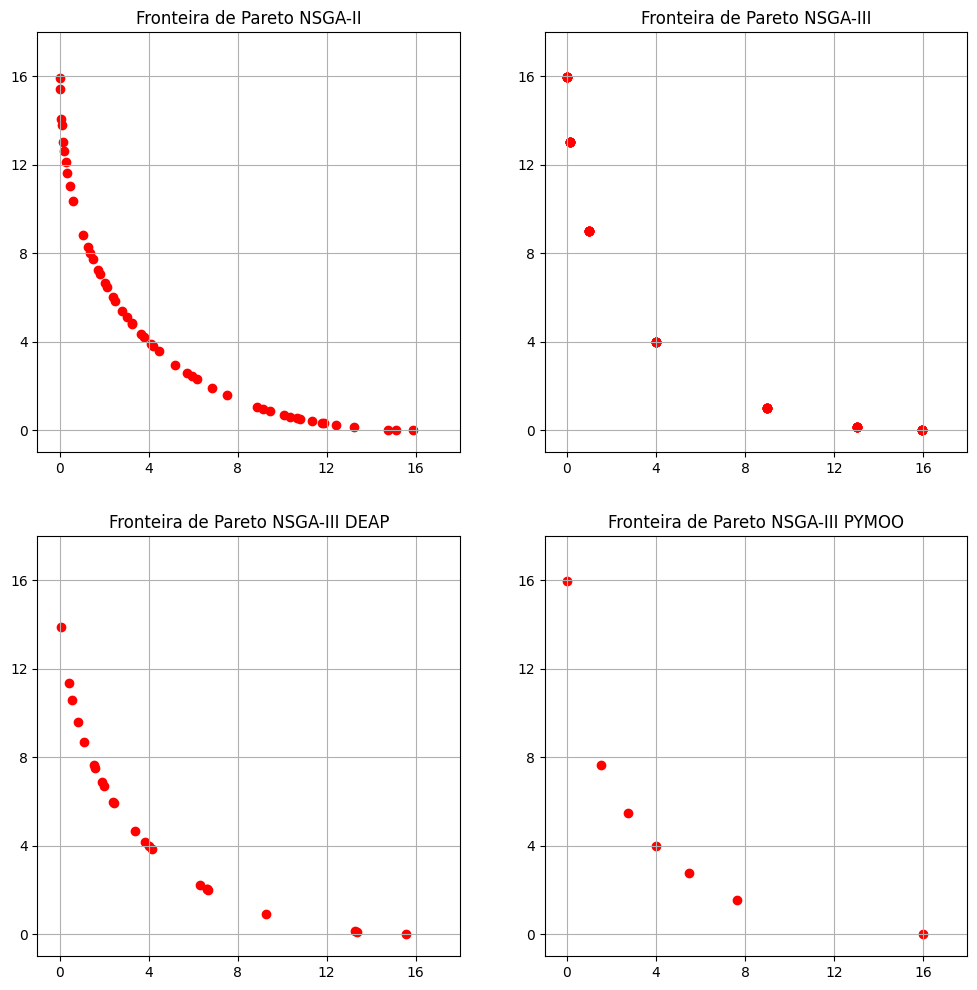

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

def plot(pareto_front, pos, text):
    plt.subplot(2, 2, pos)
    plt.scatter(*zip(*pareto_front), color="red")
    plt.title(f"Fronteira de Pareto {text}")
    plt.grid()
    plt.xticks(np.arange(0, 20, 4)) 
    plt.yticks(np.arange(0, 20, 4)) 
    plt.xlim([-1, 18])
    plt.ylim([-1, 18])

pop_size = 50
generations = 100
bounds = [-5,5]
divisions = 6

p1 = nsga2(pop_size=pop_size, generations=generations, bounds=bounds)
p2 = nsga3(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)
p3 = nsga3_deap(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)
p4 = nsga3_pymoo(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions)

plot(p1, 1, "NSGA-II")
plot(p2, 2, "NSGA-III")
plot(p3, 3, "NSGA-III DEAP")
plot(p4, 4, "NSGA-III PYMOO")

#### Todos com a mesma População Inicial

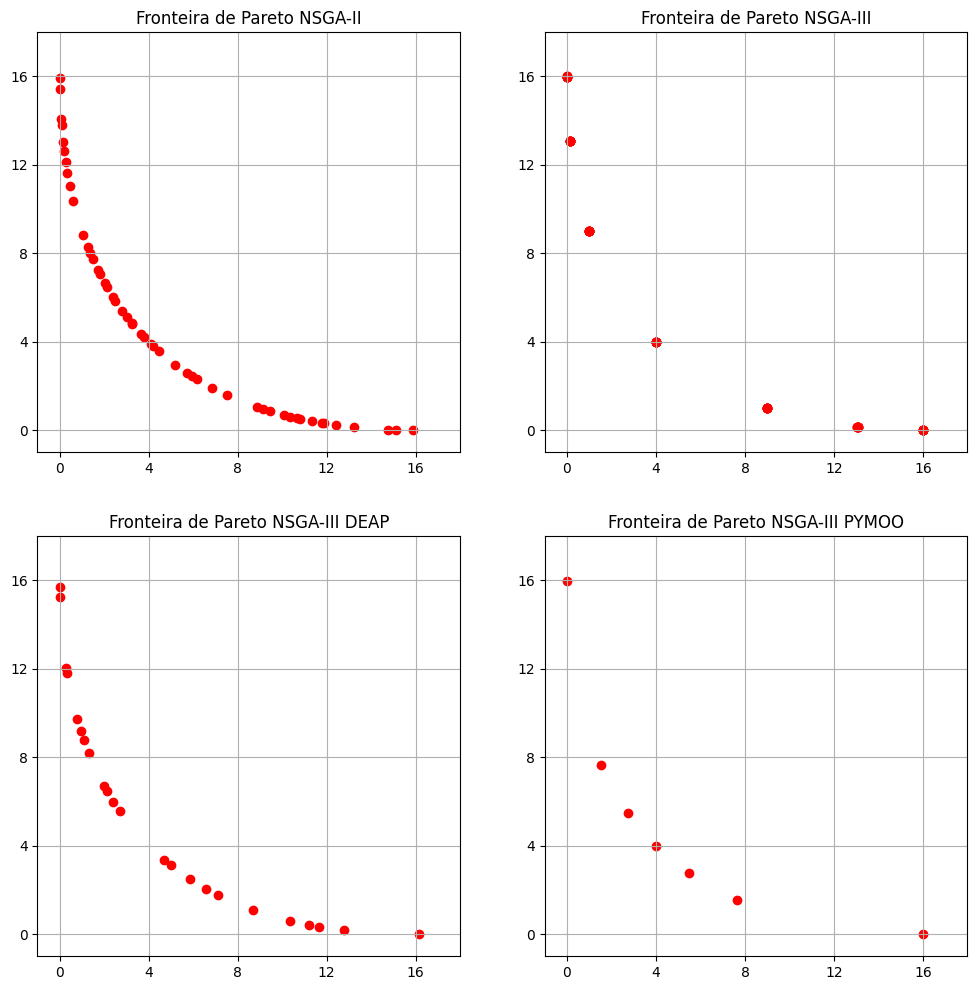

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

def plot(pareto_front, pos, text):
    plt.subplot(2, 2, pos)
    plt.scatter(*zip(*pareto_front), color="red")
    plt.title(f"Fronteira de Pareto {text}")
    plt.grid()
    plt.xticks(np.arange(0, 20, 4)) 
    plt.yticks(np.arange(0, 20, 4)) 
    plt.xlim([-1, 18])
    plt.ylim([-1, 18])

pop_size = 50
generations = 100
bounds = [-5,5]
divisions = 6
initial_population = [random.uniform(bounds[0], bounds[1]) for _ in range(pop_size)]

p1 = nsga2(pop_size=pop_size, generations=generations, bounds=bounds, initial_population=initial_population)
p2 = nsga3(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions, initial_population=initial_population)
initial_population = [[x] for x in initial_population]
p3 = nsga3_deap(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions, initial_population=initial_population)
p4 = nsga3_pymoo(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions, initial_population=initial_population)

plot(p1, 1, "NSGA-II")
plot(p2, 2, "NSGA-III")
plot(p3, 3, "NSGA-III DEAP")
plot(p4, 4, "NSGA-III PYMOO")

#### Mesma População Inicial e mesmos Pontos de Referência

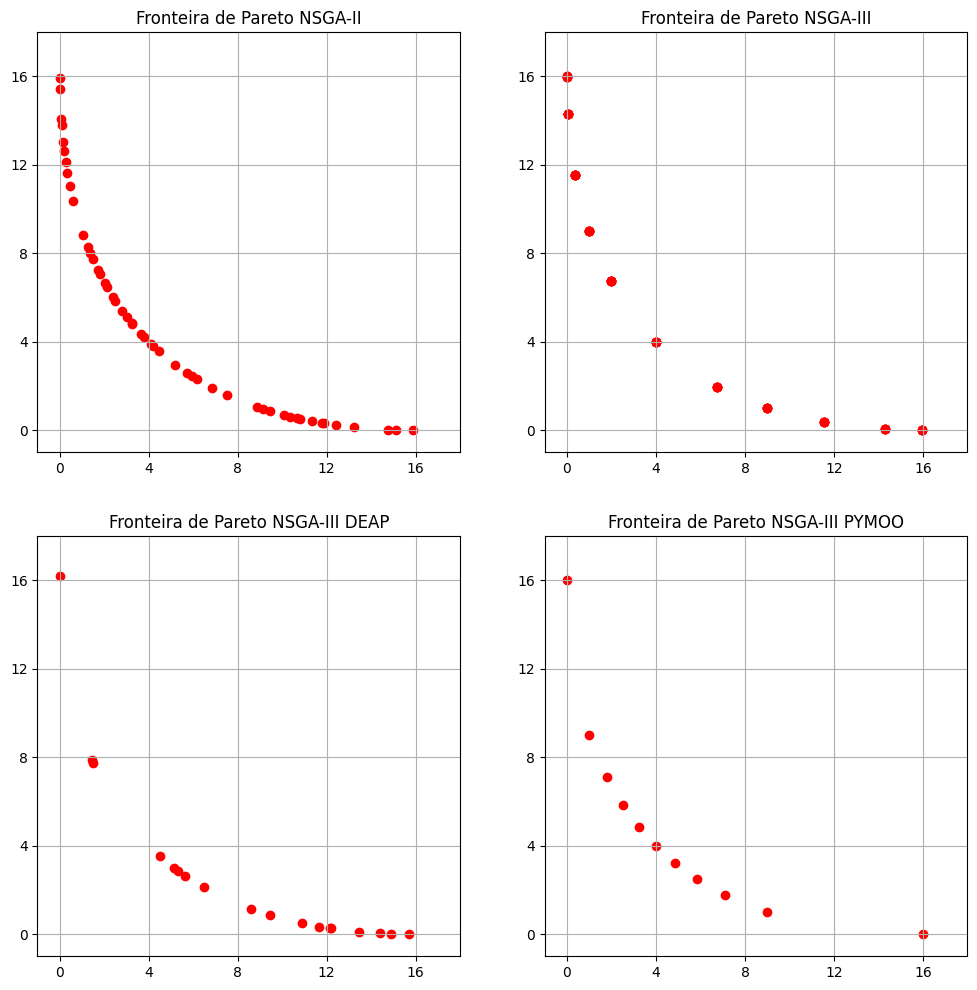

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

def plot(pareto_front, pos, text):
    plt.subplot(2, 2, pos)
    plt.scatter(*zip(*pareto_front), color="red")
    plt.title(f"Fronteira de Pareto {text}")
    plt.grid()
    plt.xticks(np.arange(0, 20, 4)) 
    plt.yticks(np.arange(0, 20, 4)) 
    plt.xlim([-1, 18])
    plt.ylim([-1, 18])

pop_size = 50
generations = 100
bounds = [-5,5]
divisions = 10
initial_population = [random.uniform(bounds[0], bounds[1]) for _ in range(pop_size)]
ref_points = tools.uniform_reference_points(nobj=2, p=divisions)

p1 = nsga2(pop_size=pop_size, generations=generations, bounds=bounds, initial_population=initial_population)
p2 = nsga3(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions, initial_population=initial_population, ref_points=ref_points)
initial_population = [[x] for x in initial_population]
p3 = nsga3_deap(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions, initial_population=initial_population, ref_points=ref_points)
p4 = nsga3_pymoo(pop_size=pop_size, generations=generations, bounds=bounds, divisions=divisions, initial_population=initial_population, ref_points=ref_points)

plot(p1, 1, "NSGA-II")
plot(p2, 2, "NSGA-III")
plot(p3, 3, "NSGA-III DEAP")
plot(p4, 4, "NSGA-III PYMOO")

#### Análise Adicional dos resultados p2 e p4

In [ ]:
import numpy as np

def remove_points_within_radius(points, radius=0.5):
    """
    Remove os pontos que estão dentro de uma bola de raio `radius` em R^2.
    
    :param points: array Nx2 de pontos em R^2.
    :param radius: Raio da bola em torno de cada ponto.
    :return: Array com os pontos restantes.
    """
    points = np.array(points)  # Garantir que seja um array NumPy
    remaining = []  # Lista para armazenar os pontos que não serão removidos

    # Iterar pelos pontos
    for i, point in enumerate(points):
        # Verificar se o ponto está dentro do raio de algum já incluído
        if all(np.linalg.norm(point - np.array(p)) > radius for p in remaining):
            remaining.append(point)  # Adicionar ponto à lista de pontos restantes

    return np.array(remaining)


# Aplicar a função para remover pontos dentro do raio
filtered_points = remove_points_within_radius(p2, radius=0.5)

print("Resultado p2:")
print(p2)
# Exibir os resultados
print("Pontos de p2 filtrados:")
print(filtered_points)
print("Resultado p4:")
print(p4)

Resultado p2:
[(5.597351856344424e-11, 16.00005985241756), (5.597351856344424e-11, 16.00005985241756), (1.1680159171123226e-08, 15.99913541339948), (6.774892740171921e-08, 15.997917777818657), (3.6928986597332845e-07, 15.995138831321045), (0.047034908074034355, 14.31203228077395), (0.04703813335558722, 14.311976020704405), (0.0470776766229434, 14.311286415016763), (0.0471146052009281, 14.310642684074818), (0.047159939588034536, 14.309852789532464), (0.3605226125708656, 11.557039792310611), (0.3605226125708656, 11.557039792310611), (0.3605226125708656, 11.557039792310611), (0.3605226125708656, 11.557039792310611), (0.3605226125708656, 11.557039792310611), (0.9997571223995964, 9.000728691797905), (0.9997571223995964, 9.000728691797905), (0.9997571223995964, 9.000728691797905), (0.9997571223995964, 9.000728691797905), (0.9997571223995964, 9.000728691797905), (1.9603442699981406, 6.759360684621319), (1.9603442699981406, 6.759360684621319), (1.9603442699981406, 6.759360684621319), (1.960344

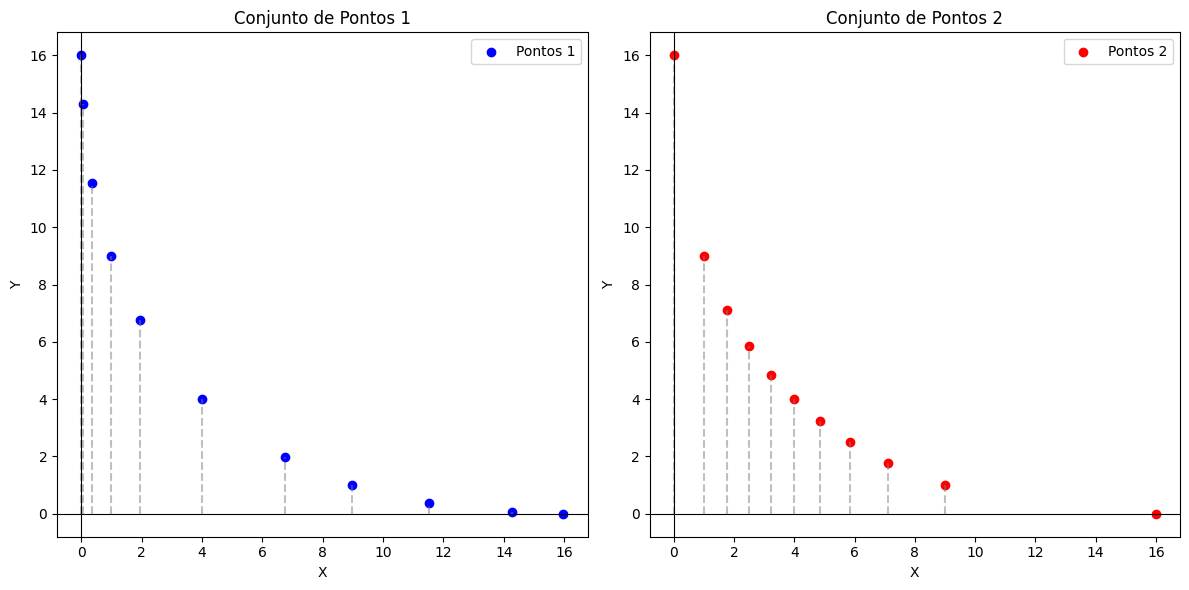

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_points_with_projections(points1, points2):
    """
    Plota dois conjuntos de pontos em gráficos separados com projeções no eixo X.

    :param points1: Primeira lista de pontos (array Nx2).
    :param points2: Segunda lista de pontos (array Nx2).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot para o primeiro conjunto de pontos
    axes[0].scatter(points1[:, 0], points1[:, 1], color='blue', label="Pontos 1")
    for x, y in points1:
        axes[0].plot([x, x], [0, y], linestyle='--', color='gray', alpha=0.5)
    axes[0].axhline(0, color='black', linewidth=0.8)
    axes[0].axvline(0, color='black', linewidth=0.8)
    axes[0].set_title("Conjunto de Pontos 1")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].legend()

    # Plot para o segundo conjunto de pontos
    axes[1].scatter(points2[:, 0], points2[:, 1], color='red', label="Pontos 2")
    for x, y in points2:
        axes[1].plot([x, x], [0, y], linestyle='--', color='gray', alpha=0.5)
    axes[1].axhline(0, color='black', linewidth=0.8)
    axes[1].axvline(0, color='black', linewidth=0.8)
    axes[1].set_title("Conjunto de Pontos 2")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Listas de pontos
points1 = np.array(filtered_points)

points2 = np.array(p4)

# Plotar os pontos com projeções
plot_points_with_projections(points1, points2)
